# Example notebook - windowed diversity calculations

This notebook provides examples of calculating windowed diversity metrics using equally-accessible windows.

## Setup

In [1]:
import intake
import allel
import pandas as pd
import numpy as np
import dask.array as da
import zarr
import fsspec
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import seaborn as sns
sns.set_context('paper')
mpl.rcParams['figure.dpi'] = 120

### Cluster setup

Needed for allele count computations.

In [2]:
from dask_kubernetes import KubeCluster
from dask.distributed import Client
cluster = KubeCluster(n_workers=10)
client = Client(cluster)
client

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:  tcp://10.33.119.35:41955
distributed.scheduler - INFO -   dashboard at:                     :8787
distributed.scheduler - INFO - Receive client connection: Client-fed8e2a8-0f86-11eb-8238-126c7f3bddb6
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.33.119.35:41955 Dashboard: /user/alimanfoo@googlemail.com/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


distributed.scheduler - INFO - Register tcp://10.32.197.9:35649
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.197.9:35649
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.123.30:42519
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.123.30:42519
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.200.9:41259
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.200.9:41259
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.203.5:40181
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.203.5:40181
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.120.54:37321
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.120.54:37321
distribut

### Data setup

#### Reference genome

Needed for accessibility calculations.

In [3]:
# reference genome
genome = zarr.open_consolidated(
    store=fsspec.get_mapper(
        'gs://vo_agam_release/reference/genome/agamp4/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.zarr'
    )
)
list(genome)

['2L', '2R', '3L', '3R', 'Mt', 'UNKN', 'X', 'Y_unplaced']

#### Ag 3

In [4]:
cat = intake.open_catalog('https://malariagen.github.io/intake/gcs.yml')
list(cat.ag3)

['sample_sets',
 'samples',
 'species_calls_20200422_aim',
 'species_calls_20200422_pca',
 'snp_sites',
 'snp_genotypes',
 'site_filters_dt_20200416_arab',
 'site_filters_dt_20200416_gamb_colu',
 'site_filters_dt_20200416_gamb_colu_arab']

In [5]:
def load_mask(seq_id, mask, filters_analysis="dt_20200416"):
    """Load a site filter mask.
    
    Parameters
    ----------
    seq_id : str
        Chromosome arm.
    mask : {"gamb_colu", "arab", "gamb_colu_arab"}
        Mask species combination.
    filters_analysis : str
        Filtering model.

    Returns
    -------
    filter_pass: numpy array
        Boolean array where True means pass.

    """ 
    
    callset_filters = cat.ag3[f"site_filters_{filters_analysis}_{mask}"].to_zarr()
    filter_pass = callset_filters[seq_id]["variants/filter_pass"][:]

    return filter_pass


def load_variants_array(seq_id, field, mask=None, filters_analysis="dt_20200416"):
    """Load sites data.
    
    Parameters
    ----------
    seq_id : str
        Chromosome arm.
    field : {"REF", "ALT", "POS"}
        Array to load.
    mask : {"gamb_colu", "arab", "gamb_colu_arab"}
        Mask species combination.
    filters_analysis : str
        Filtering model.

    Returns
    -------
    arr : numpy array

    """
    
    callset_sites = cat.ag3.snp_sites.to_zarr()
    arr = da.from_zarr(callset_sites[seq_id]["variants"][field])

    if mask is not None:
        filter_pass = load_mask(seq_id, mask, filters_analysis)
        arr = da.compress(filter_pass, arr, axis=0)

    return arr.compute()


def load_calldata_array(seq_id, sample_set, field, mask=None, filters_analysis="dt_20200416", wrap_gt=True):
    """Load SNP genotype calldata for a given sample set.

    Parameters
    ----------
    seq_id : str
        Chromosome arm.
    sample_set : str
        Sample set.
    field : {"GT", "GQ", "AD", "MQ"}
        Array to load.
    mask : {"gamb_colu", "arab", "gamb_colu_arab"}
        Mask species combination.
    filters_analysis : str
        Filtering model.

    Returns
    -------
    arr : dask.Array
    
    """
    
    if isinstance(sample_set, str):
        # load data for a single sample set
        callset_genotypes = cat.ag3.snp_genotypes(sample_set=sample_set).to_zarr()
        arr = da.from_zarr(callset_genotypes[f"{seq_id}/calldata/{field}"])
                
    elif isinstance(sample_set, (list, tuple)):
        # load data for multiple sample sets
        # ***********************************************************************
        # N.B., use the wrap_gt=False option to avoid dask errors on google cloud
        # ***********************************************************************
        arr = da.concatenate(
            [load_calldata_array(
                seq_id=seq_id, 
                sample_set=x, 
                field=field, 
                mask=None,
                wrap_gt=False) for x in sample_set], 
            axis=1)
    
    else:
        raise TypeError("Type of `sample_set` must be string or list of strings")
        
    if mask is not None:
    
        filter_pass = load_mask(seq_id, mask, filters_analysis)
        arr = da.compress(filter_pass, arr, axis=0)

    if field == "GT" and wrap_gt:
        arr = allel.GenotypeDaskArray(arr)
            
    return arr


def load_sample_metadata(sample_set, 
                         include_aim_species_calls=True, 
                         include_pca_species_calls=False, 
                         species_analysis="species_calls_20200422"):
    """Load sample metadata, optionally including species calls.

    Parameters
    ----------
    sample_set : str
        Sample set.
    include_aim_species_calls : bool
        If True, include AIM calls.
    include_pca_species_calls : bool
        If True, include PCA calls.
    species_analysis : str
        Species analysis.

    Returns
    -------
    df : pandas.DataFrame

    Notes
    -----
    If both AIMs and PCA are requested, species calls columns are appended with 
    "_aim" and "_pca" respectively.

    """

    if isinstance(sample_set, str):

        df = cat.ag3.samples(sample_set=sample_set).read()
        df["sample_set"] = sample_set

        if include_aim_species_calls:
            df_aim = cat.ag3[f"{species_analysis}_aim"](sample_set=sample_set).read()
            
        if include_pca_species_calls:
            df_pca = cat.ag3[f"{species_analysis}_pca"](sample_set=sample_set).read()

        df_species = None

        if include_aim_species_calls and include_pca_species_calls:
            df_species = df_aim.merge(df_pca, on="sample_id", lsuffix="_aim", rsuffix="_pca", sort=False)
            
        elif include_aim_species_calls:
            df_species = df_aim
            
        elif include_pca_species_calls:
            df_species = df_species

        if df_species is not None:
            df = df.merge(df_species, on="sample_id", sort=False)
    
        return df

    elif isinstance(sample_set, (list, tuple)):

        return pd.concat(
            [load_sample_metadata(
                sample_set=s, 
                include_aim_species_calls=include_aim_species_calls, 
                include_pca_species_calls=include_pca_species_calls, 
                species_analysis=species_analysis) 
             for s in sample_set],
            axis=0, sort=False)
    
    else:
        raise TypeError("Type of `sample_set` must be string or list of strings")


In [6]:
df_sample_sets = cat.ag3.sample_sets.read()

/opt/conda/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
all_wild = [x for x in df_sample_sets.sample_set if x != "AG1000G-X"]

In [8]:
df_meta = load_sample_metadata(sample_set=all_wild)
# reset index for concatenated sample sets
df_meta.reset_index(inplace=True, drop=True)
# call species
df_meta['species'] = 'unknown'
df_meta.loc[df_meta.species_gambcolu_arabiensis == 'arabiensis', 'species'] = 'arabiensis'
df_meta.loc[df_meta.species_gambcolu_arabiensis == 'intermediate', 'species'] = 'intermediate_arabiensis_gambiae'
df_meta.loc[(df_meta.species_gambcolu_arabiensis == 'gamb_colu') & (df_meta.species_gambiae_coluzzii == 'gambiae'), 'species'] = 'gambiae'
df_meta.loc[(df_meta.species_gambcolu_arabiensis == 'gamb_colu') & (df_meta.species_gambiae_coluzzii == 'coluzzii'), 'species'] = 'coluzzii'
df_meta.loc[(df_meta.species_gambcolu_arabiensis == 'gamb_colu') & (df_meta.species_gambiae_coluzzii == 'intermediate'), 'species'] = 'intermediate_gambiae_coluzzii'
# special-case locations for scattered sample sets
df_meta.loc[df_meta.sample_set == 'AG1000G-ML-B', 'location'] = 'misc'
df_meta.loc[df_meta.sample_set == 'AG1000G-CM-B', 'location'] = 'misc'
df_meta.loc[df_meta.sample_set == 'AG1000G-CM-C', 'location'] = 'misc'
df_meta.loc[df_meta.sample_set == 'AG1000G-FR', 'location'] = 'misc'
df_meta

,sample_id,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,sample_set,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii,species
0,AR0047-C,LUA047,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.945,0.001,gamb_colu,coluzzii,coluzzii
1,AR0049-C,LUA049,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.933,0.001,gamb_colu,coluzzii,coluzzii
2,AR0051-C,LUA051,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.937,0.002,gamb_colu,coluzzii,coluzzii
3,AR0061-C,LUA061,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.938,0.002,gamb_colu,coluzzii,coluzzii
4,AR0078-C,LUA078,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.926,0.001,gamb_colu,coluzzii,coluzzii
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2779,AC0295-C,K92,Martin Donnelly,Uganda,Kihihi,2012,11,-0.751,29.701,F,AG1000G-UG,0.026,0.002,gamb_colu,gambiae,gambiae
2780,AC0296-C,K93,Martin Donnelly,Uganda,Kihihi,2012,11,-0.751,29.701,F,AG1000G-UG,0.029,0.003,gamb_colu,gambiae,gambiae
2781,AC0297-C,K94,Martin Donnelly,Uganda,Kihihi,2012,11,-0.751,29.701,F,AG1000G-UG,0.026,0.002,gamb_colu,gambiae,gambiae
2782,AC0298-C,K95,Martin Donnelly,Uganda,Kihihi,2012,11,-0.751,29.701,F,AG1000G-UG,0.029,0.002,gamb_colu,gambiae,gambiae


## Example analyses

Here we analyse chromosome arm 3R in a single population, for illustration.

Initially we will analyse the whole chromosome arm. Later we will analyse only the euchromatic portion.

In [ ]:
# setup genotypes
gt = load_calldata_array(seq_id='3R', sample_set=all_wild, field='GT')
gt

In [ ]:
# choose a population to work with
loc_pop = (
    df_meta
    .query("(country == 'Burkina Faso') and (location == 'Bana') and (year == 2012) and (species == 'gambiae')")
    .index
    .values
)
loc_pop

In [ ]:
# subset the genotypes
gt_pop = gt.take(loc_pop, axis=1)
gt_pop

In [ ]:
# load variant positions and site filters
site_mask = load_mask('3R', 'gamb_colu')
site_mask

In [13]:
gt_pop_masked = gt_pop.compress(site_mask, axis=0)
gt_pop_masked

<GenotypeDaskArray shape=(37199402, 22, 2) dtype=int8>

In [14]:
pos = load_variants_array('3R', 'POS')
pos

array([       1,        2,        3, ..., 53200682, 53200683, 53200684],
      dtype=int32)

In [15]:
pos_masked = pos.compress(site_mask, axis=0)
pos_masked

array([     180,      185,      236, ..., 53196502, 53196504, 53196522],
      dtype=int32)

In [17]:
%%time
ac_pop_masked = gt_pop_masked.count_alleles(max_allele=3).compute()
ac_pop_masked

CPU times: user 4.87 s, sys: 2.5 s, total: 7.37 s
Wall time: 9.42 s


<AlleleCountsArray shape=(37199402, 4) dtype=int32>
44  0  0  0
44  0  0  0
44  0  0  0
...
44  0  0  0
44  0  0  0
44  0  0  0

### Nucleotide diversity - method 1

This method uses the general approach in scikit-allel for computing nucleotide diversity in equally accessible windows.

**Note that in order to construct the is_accessible array, this must be the full length of the chromosome arm, including N positions. Therefore, the is_accessible array is not the same as the site_mask array, which has N positions removed already.**

In [17]:
seq_len = len(genome['3R'])
seq_len

53200684

In [18]:
is_accessible = np.zeros(seq_len, dtype=bool)
is_accessible[pos - 1] = site_mask
np.count_nonzero(is_accessible)

37199402

In [19]:
windows = allel.equally_accessible_windows(is_accessible, size=50_000)
windows

array([[     180,    63121],
       [   63122,   122482],
       [  122483,   179666],
       ...,
       [52335590, 52497563],
       [52497564, 52776596],
       [52776597, 52910413]])

In [20]:
pi, _, n_bases, counts = allel.windowed_diversity(
    pos=pos_masked, 
    ac=ac_pop_masked, 
    windows=windows, 
    is_accessible=is_accessible
)

In [21]:
# check that number of accessible bases per window is always 50,000
np.all(n_bases == 50_000)

True

In [22]:
# check that number of variants per window is always 50,000
np.all(counts == 50_000)

True

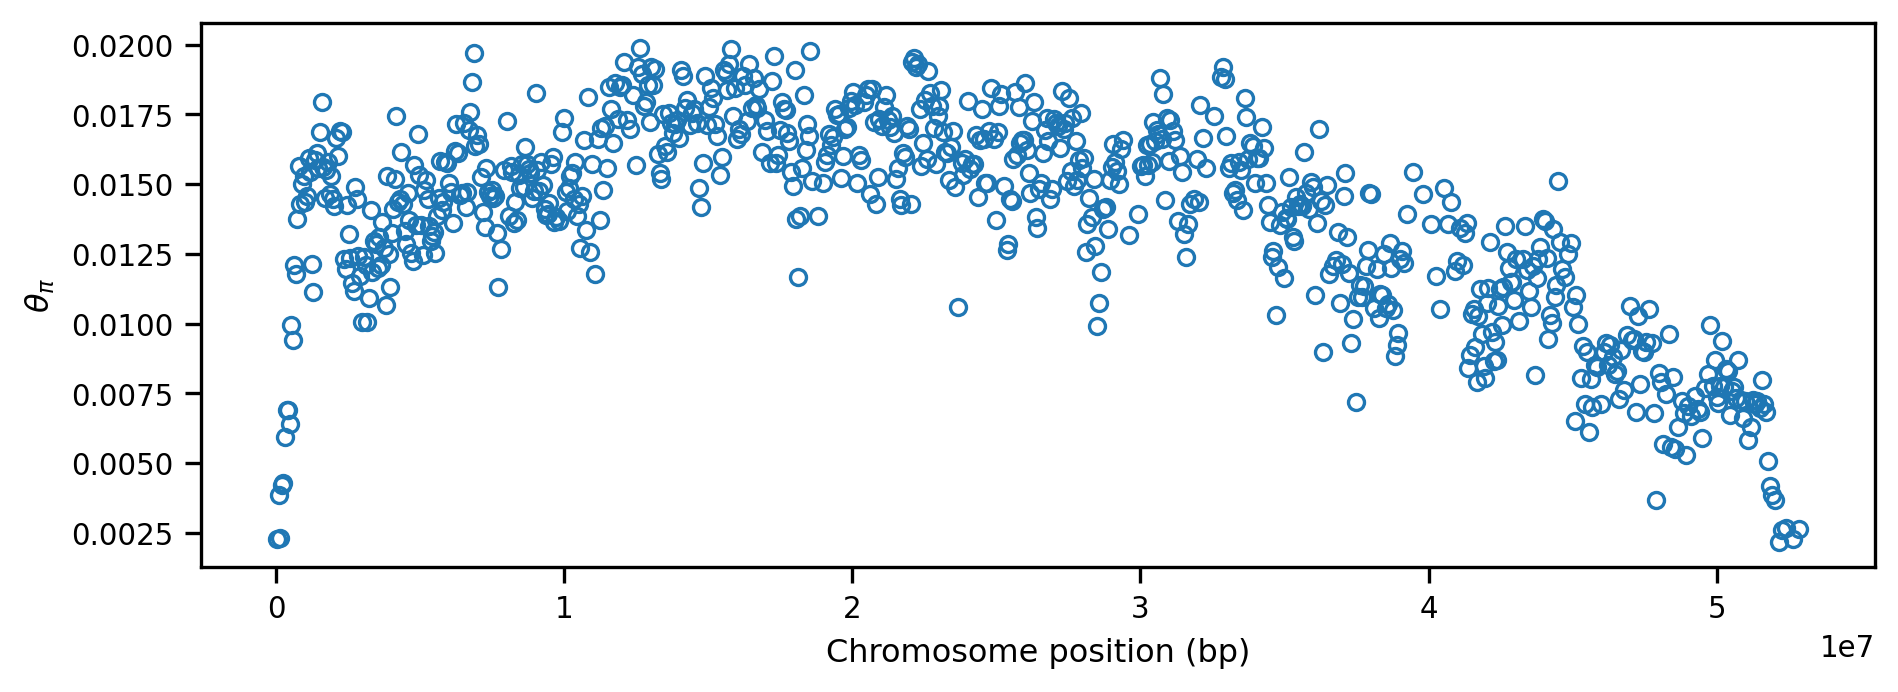

In [23]:
# plot to check
x = windows.mean(axis=1)
y = pi
fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(x, y, marker='o', mfc='none', linestyle=' ')
ax.set_xlabel('Chromosome position (bp)')
ax.set_ylabel(r'$\theta_{\pi}$');

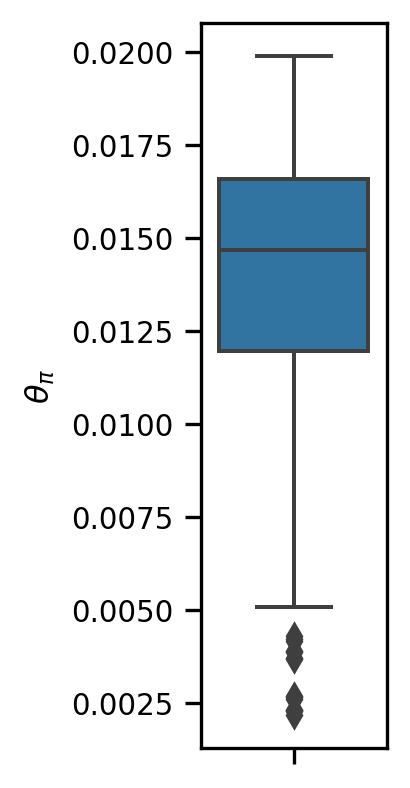

In [24]:
fig, ax = plt.subplots(figsize=(1, 4))
sns.boxplot(y=pi, orient='v', ax=ax)
ax.set_ylabel(r'$\theta_{\pi}$');

### Nucleotide diversity - method 2

This method leverages the fact that we have genotyped all accessible sites, not just variants. The result should be the same as method 1.

In [25]:
window_size = 50_000
x2 = allel.moving_statistic(
    values=pos_masked, 
    statistic=np.mean, 
    size=window_size
)
y2 = allel.moving_statistic(
    values=ac_pop_masked, 
    statistic=lambda v: np.nansum(allel.mean_pairwise_difference(v))/window_size, 
    size=window_size
)

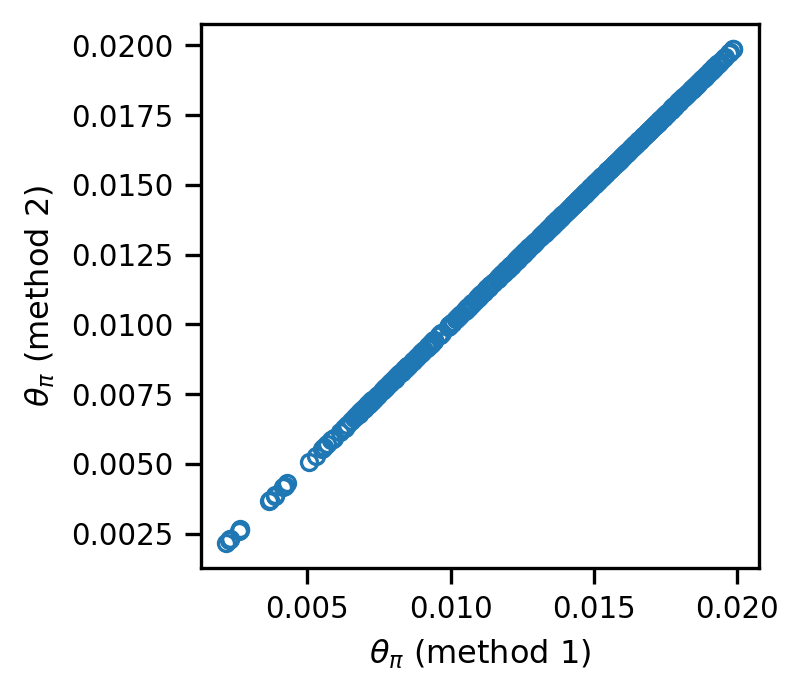

In [26]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(y, y2, marker='o', mfc='none', linestyle=' ')
ax.set_xlabel(r'$\theta_{\pi}$ (method 1)')
ax.set_ylabel(r'$\theta_{\pi}$ (method 2)');

### Nucleotide diversity - selecting euchromatic region

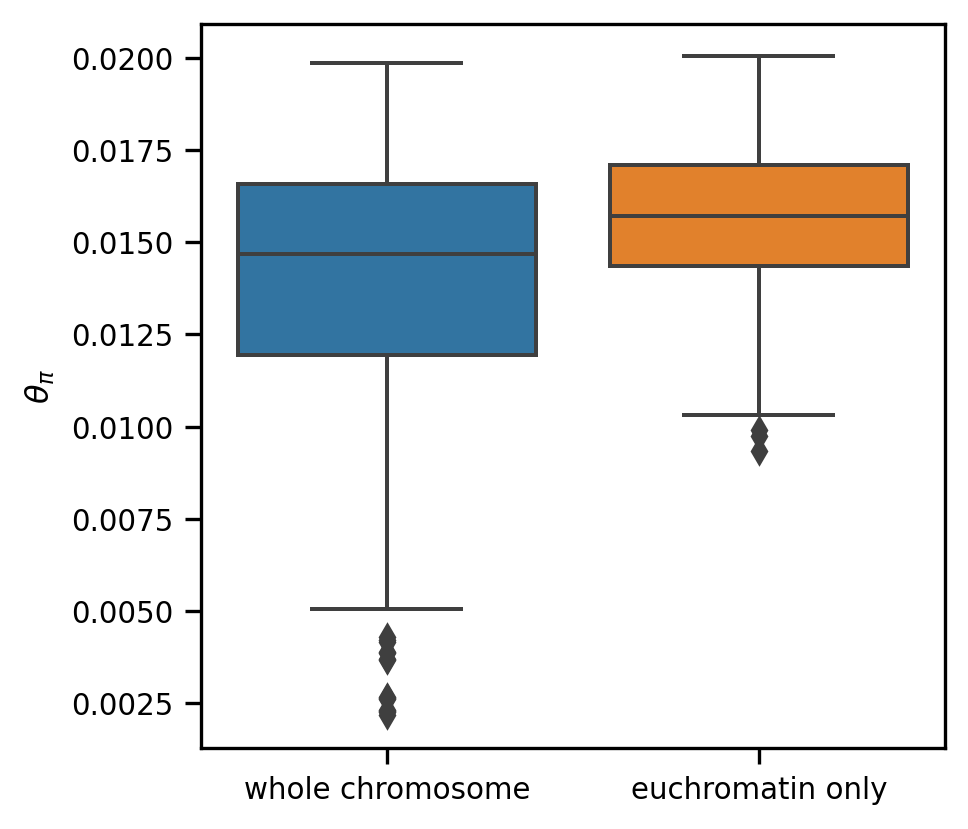

In [27]:
# method 1
windows_euchromatin = allel.equally_accessible_windows(
    is_accessible, 
    size=50_000, 
    start=1_000_000,
    stop=37_000_000
)
pi_euchromatin, _, _, _ = allel.windowed_diversity(
    pos=pos_masked, 
    ac=ac_pop_masked, 
    windows=windows_euchromatin, 
    is_accessible=is_accessible
)

# for interest, compare whole genome (WG) and euchromatic region (EUCH)
fig, ax = plt.subplots(figsize=(4, 4))
sns.boxplot(x=['whole chromosome', 'euchromatin only'], y=[pi, pi_euchromatin], orient='v', ax=ax)
ax.set_ylabel(r'$\theta_{\pi}$');

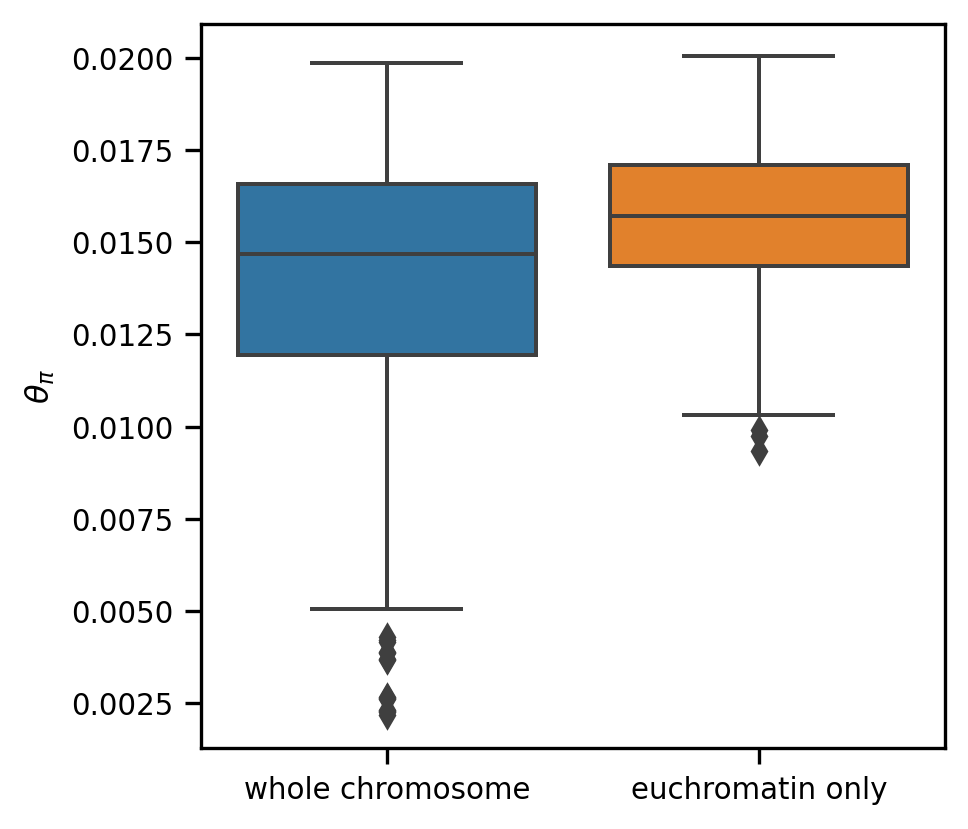

In [28]:
# method 2
loc_region = allel.SortedIndex(pos_masked).locate_range(1_000_000, 37_000_000)
ac_pop_masked_region = ac_pop_masked[loc_region]
window_size = 50_000
pi_euchromatin = allel.moving_statistic(
    values=ac_pop_masked_region, 
    statistic=lambda v: np.nansum(allel.mean_pairwise_difference(v))/window_size, 
    size=window_size
)

# for interest, compare whole genome (WG) and euchromatic region (EUCH)
fig, ax = plt.subplots(figsize=(4, 4))
sns.boxplot(x=['whole chromosome', 'euchromatin only'], y=[pi, pi_euchromatin], orient='v', ax=ax)
ax.set_ylabel(r'$\theta_{\pi}$');

### Watterson's theta

I'll only show method 1 here, method 2 is also doable but not sure worth showing.

In [29]:
windows_euchromatin = allel.equally_accessible_windows(
    is_accessible, 
    size=50_000, 
    start=1_000_000,
    stop=37_000_000
)
theta_w_euchromatin, _, _, _ = allel.windowed_watterson_theta(
    pos=pos_masked, 
    ac=ac_pop_masked, 
    windows=windows_euchromatin, 
    is_accessible=is_accessible
)

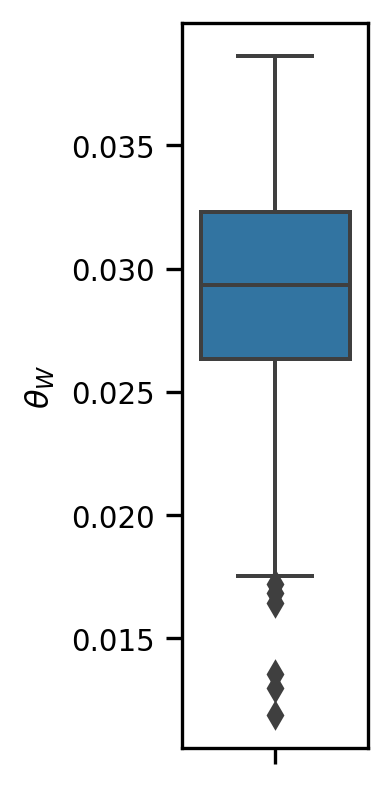

In [30]:
fig, ax = plt.subplots(figsize=(1, 4))
sns.boxplot(y=theta_w_euchromatin, orient='v', ax=ax)
ax.set_ylabel(r'$\theta_{W}$');

### Tajima's D

This can always be done as a simple moving statistic, no need to accout for accessibility.

In [31]:
td_euchromatin = allel.moving_tajima_d(ac_pop_masked_region, size=50_000)

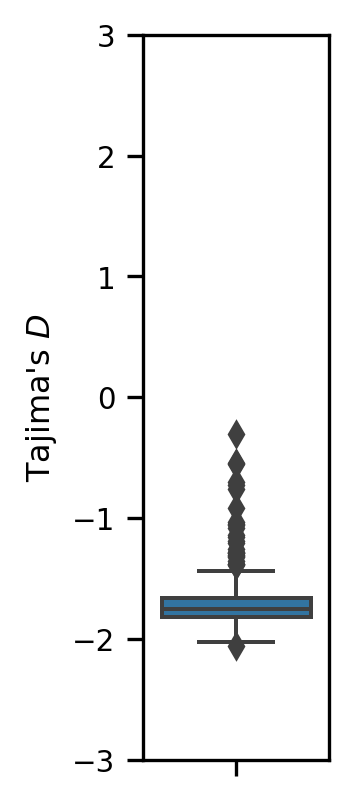

In [32]:
fig, ax = plt.subplots(figsize=(1, 4))
sns.boxplot(y=td_euchromatin, orient='v', ax=ax)
ax.set_ylabel(r"Tajima's $D$")
ax.set_ylim(-3, 3);